In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

import acquire
import prepare


#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = acquire.get_data(query_url = False)
print(df.shape)
df = prepare.prepare_dataframe(df)
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((53199, 63), (26599, 63), (26600, 63))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53199 non-null  object        
 1   name              53199 non-null  object        
 2   lang              53199 non-null  object        
 3   released_at       53199 non-null  datetime64[ns]
 4   layout            53199 non-null  object        
 5   highres_image     53199 non-null  bool          
 6   image_status      53199 non-null  object        
 7   mana_cost         53199 non-null  object        
 8   cmc               53194 non-null  float64       
 9   type_line         53194 non-null  object        
 10  oracle_text       53199 non-null  object        
 11  power             53199 non-null  object        
 12  toughness         53199 non-null  object        
 13  colors            53199 non-null  object        
 14  color_identity    5

In [4]:
train.finishes.value_counts()

[nonfoil, foil]            26591
[nonfoil]                  21381
[foil]                      4680
[etched]                     305
[nonfoil, foil, etched]      190
[foil, etched]                29
[nonfoil, etched]             19
[glossy]                       4
Name: finishes, dtype: int64

# what is the distribution of usd, usd foil

<AxesSubplot:>

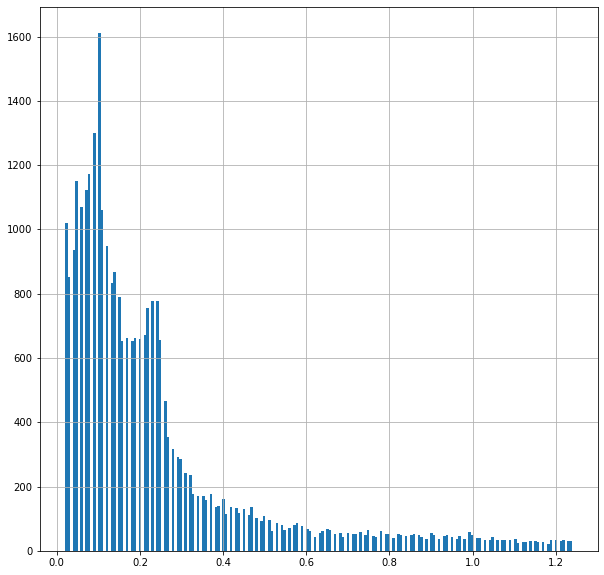

In [5]:
train['usd'] = train.usd.astype(float)
train['usd_foil'] = train.usd_foil.astype(float)
plt.figure(figsize = (10, 10))
train[(train.usd > 0.01) & (train.usd < 1.25)].usd.hist(bins=200)

In [6]:
train[['usd']].describe()

,usd
count,53199.000000
mean,5.198302
std,93.589371
min,0.000000
25%,0.010000
50%,0.130000
75%,0.480000
max,11500.000000


In [7]:
train[(train.usd > 0.01)].usd.describe()

count    39351.000000
mean         7.027403
std        108.759196
min          0.020000
25%          0.100000
50%          0.230000
75%          1.120000
max      11500.000000
Name: usd, dtype: float64

<AxesSubplot:>

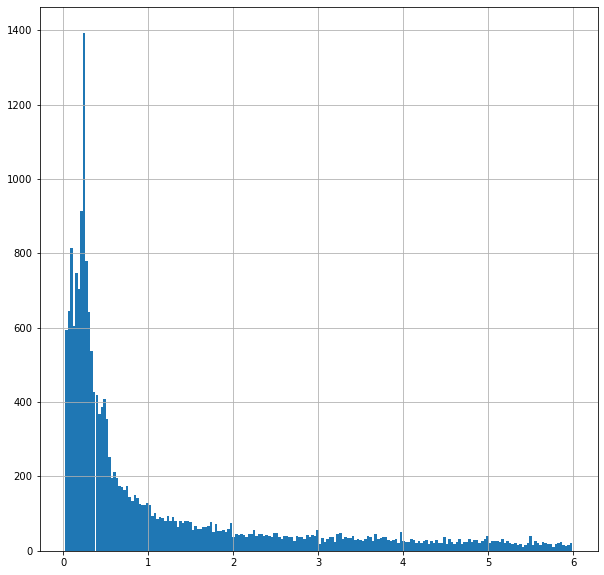

In [8]:
plt.figure(figsize = (10, 10))
train[(train.usd_foil > 0.01) & (train.usd_foil < 6.0)].usd_foil.hist(bins=200)

In [9]:
train[['usd_foil']].describe()

,usd_foil
count,53199.000000
mean,4.928907
std,33.042158
min,0.000000
25%,0.000000
50%,0.000000
75%,0.920000
max,3099.970000


In [10]:
train[(train.usd_foil > 0.01)].usd_foil.describe()

count    26293.000000
mean         9.972704
std         46.462489
min          0.020000
25%          0.260000
50%          0.960000
75%          5.760000
max       3099.970000
Name: usd_foil, dtype: float64

# Is promo significant to the usd columns?

yes

In [11]:
train.promo.value_counts()

False    47406
True      5793
Name: promo, dtype: int64

In [12]:
train[(train.usd > 0.01)].groupby('promo').usd.describe()

,count,mean,std,min,25%,50%,75%,max
promo,,,,,,,,
False,38175.0,6.956582,110.102387,0.02,0.1000,0.220,0.99,11500.00
True,1176.0,9.326352,47.774821,0.09,0.6475,1.865,5.75,1062.47


$H_0$ mean of promo cards is equal to the mean of not promo cards

$H_a$ mean of promo cards is not equal to the mean of not promo cards

In [13]:
df_promo = train[train.promo == True].usd
df_no_promo = train[train.promo != True].usd
t, p = stats.ttest_ind(df_promo, df_no_promo, equal_var=False)
t, p / 2, p < 0.05

(-6.905824096866957, 2.532602180525473e-12, True)

# is foil a driver of price?

In [14]:
train[(train.usd > 0.01)].groupby('is_foil').usd.describe()

,count,mean,std,min,25%,50%,75%,max
is_foil,,,,,,,,
False,16954.0,13.738318,165.262242,0.02,0.15,0.28,1.79,11500.0
True,22397.0,1.947398,7.004172,0.02,0.08,0.19,0.73,272.1


In [15]:
df_foil = train[train.foil == True].usd
df_no_foil = train[train.foil != True].usd
t, p = stats.ttest_ind(df_promo, df_no_promo, equal_var=False)
t, p / 2, p < 0.05

(-6.905824096866957, 2.532602180525473e-12, True)

# is penny_rank or edhrec_rank correlated with price

edhrec_rank is correlated, but not strongly

<AxesSubplot:xlabel='penny_rank', ylabel='usd'>

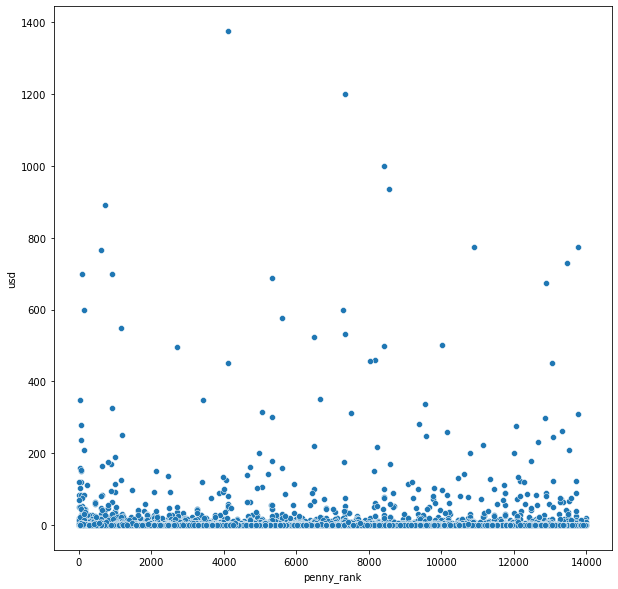

In [16]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = train[(train.usd > 0.01) &(train.penny_rank > 0)], x = 'penny_rank', y='usd')

In [17]:
corr_df = train[(train.usd > 0.01) &(train.penny_rank > 0)].loc[:,['usd', 'penny_rank']]
corr, p = stats.pearsonr(corr_df['penny_rank'], corr_df['usd'])
corr, p

(-0.0028117211199473816, 0.6674389761799918)

<AxesSubplot:xlabel='edhrec_rank', ylabel='usd'>

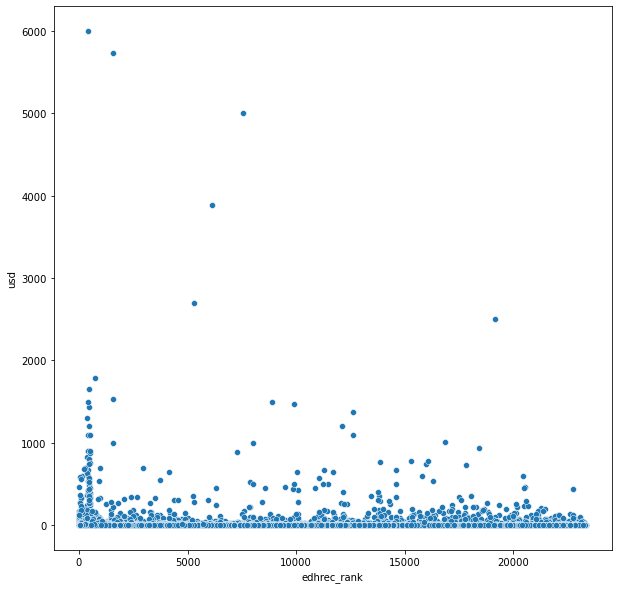

In [18]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data = train[(train.usd > 0.01) & (train.edhrec_rank > 0)], x = 'edhrec_rank', y='usd')

In [19]:
corr_df = train[(train.usd > 0.01) &(train.edhrec_rank > 0)].loc[:,['usd', 'edhrec_rank']]
corr, p = stats.pearsonr(corr_df['edhrec_rank'], corr_df['usd'])
corr, p

(-0.03324942516850023, 3.139521590780199e-10)

# is reserved significant?
yes

In [20]:
train.reserved.value_counts()

False    52169
True      1030
Name: reserved, dtype: int64

In [21]:
train[(train.usd > 0.01)].groupby('reserved').usd.describe()

,count,mean,std,min,25%,50%,75%,max
reserved,,,,,,,,
False,38774.0,3.595748,25.671023,0.02,0.10,0.22,1.00,1787.5
True,577.0,237.632218,842.410798,0.70,2.71,12.29,102.99,11500.0


In [22]:
df_reserved = train[train.reserved == True].usd
df_no_reserved = train[train.reserved != True].usd
t, p = stats.ttest_ind(df_reserved, df_no_reserved, equal_var=False)
t, p / 2, p < 0.05

(6.528894116027018, 5.194013081149936e-11, True)

# look at card types

In [23]:
def make_card_type_column(df):
    card_types = ['Creature', 'Land', 'Enchantment', 'Artifact', 'Sorcery', 'Instant', 'Legendary', 'Token']
    for card_type in card_types:
        df[f'is_{card_type.lower()}'] = df.type_line.str.contains(card_type).fillna(False)
    df[f'is_split_card'] = df.type_line.str.contains('Card // Card').fillna(False)
    return df

In [24]:
make_card_type_column(train)

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,is_glossy,is_creature,is_land,is_enchantment,is_artifact,is_sorcery,is_instant,is_legendary,is_token,is_split_card
12661,2d911053-a026-4b20-ba2d-dbcc367c1413,Ajani Goldmane,en,2010-07-16,normal,True,highres_scan,{2}{W}{W},4.0,Legendary Planeswalker — Ajani,...,False,False,False,False,False,False,False,True,False,False
61300,dcb2e0d6-3181-4d3d-a3b4-3896288b2e0e,Champion of Lambholt,en,2020-08-07,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Human Warrior,...,False,True,False,False,False,False,False,False,False,False
48604,af3aa149-00fa-4932-b004-f64c8b5d3ca7,Gargoyle,en,2009-07-17,token,True,highres_scan,,0.0,Token Artifact Creature — Gargoyle,...,False,True,False,False,True,False,False,False,True,False
55734,c8d75604-4941-4faf-8f1a-7fc529e64962,Goblin Settler,en,2022-04-12,normal,True,highres_scan,{3}{R},4.0,Creature — Goblin,...,False,True,False,False,False,False,False,False,False,False
70638,feef03a1-f19a-413b-ad86-0b357cf9c09c,Weight Advantage,en,2016-08-26,normal,True,highres_scan,,0.0,Conspiracy,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,1e81e5fc-0e18-4dd8-a505-aa7dba8521a8,Kaboom!,en,2002-10-07,normal,True,highres_scan,{4}{R},5.0,Sorcery,...,False,False,False,False,False,True,False,False,False,False
54821,c59e3dd0-9cd4-4c65-9296-e2020a0df857,"Vraska, Relic Seeker",en,2017-09-29,normal,True,highres_scan,{4}{B}{G},6.0,Legendary Planeswalker — Vraska,...,False,False,False,False,False,False,False,True,False,False
66803,f0c02fd3-8051-4a35-b14a-462d765f42e5,Veteran Motorist,en,2020-11-12,normal,False,lowres,{R}{W},2.0,Creature — Dwarf Pilot,...,False,True,False,False,False,False,False,False,False,False
68710,f7ae5085-0d0d-4d7d-80a3-614315a07de5,"Liliana, the Last Hope",en,2022-07-08,normal,False,lowres,{1}{B}{B},3.0,Legendary Planeswalker — Liliana,...,False,False,False,False,False,False,False,True,False,False


# checking boolean columns

boolean column initially look important but note foil/nonfoil columns

In [25]:
def make_boolean_t_test(df, alpha = 0.05):
    bool_list = list(df.select_dtypes(include='bool').columns)

    outputs = []
    for col in bool_list:
        df_is = df[df[col] == True].usd
        df_is_not = df[df[col] != True].usd
        stat_levene, p_levene = stats.levene(df_is, df_is_not)
        t, p = stats.ttest_ind(df_is, df_is_not, equal_var = not (p_levene < alpha))
        
        df_foil_is = df[df[col] == True].usd_foil
        df_foil_is_not = df[df[col] != True].usd_foil
        stat_levene, p_levene = stats.levene(df_foil_is, df_foil_is_not)
        t_foil, p_foil = stats.ttest_ind(df_foil_is, df_foil_is_not, equal_var = not (p_levene < alpha))
        output = {
            'column':col,
            'target':'usd',
            't_stat':t,
            'p_value':p,
            'reject_null':p <0.05
        }
        output_foil = {
            'column':col,
            'target':'usd_foil',
            't_stat':t_foil,
            'p_value':p_foil,
            'reject_null':p_foil <0.05
        }
        outputs.append(output)
        outputs.append(output_foil)
    return pd.DataFrame(outputs)

In [26]:
make_boolean_t_test(train).sort_values(['reject_null', 'column'], ascending=False)

,column,target,t_stat,p_value,reject_null
2,reserved,usd,6.528894,1.038803e-10,True
3,reserved,usd_foil,2.378531,1.756301e-02,True
13,reprint,usd_foil,-6.495615,8.372813e-11,True
10,promo,usd,-6.905824,5.065204e-12,True
11,promo,usd_foil,7.957153,2.074567e-15,True
9,oversized,usd_foil,-8.543889,2.822644e-16,True
6,nonfoil,usd,12.813155,1.593856e-37,True
7,nonfoil,usd_foil,-12.122769,2.252748e-33,True
49,is_token,usd_foil,-18.667473,5.933301e-73,True
51,is_split_card,usd_foil,-34.411655,1.240219e-256,True


In [27]:
train.foil.value_counts()

True     31490
False    21709
Name: foil, dtype: int64

In [28]:
train.nonfoil.value_counts()

True     48181
False     5018
Name: nonfoil, dtype: int64

# is the keywords column meaningful?

it is not

In [29]:
def make_keywords_df(df):
    keywords_corpus = []
    for row in df.keywords:
        keywords_corpus += row
    keywords_corpus = list(set(keywords_corpus))
    df_keywords = df.loc[:,['usd', 'usd_foil']]
    f_keywords = []
    for keyword in keywords_corpus:
        formatted_keyword = re.sub(r'[^\w]', '', keyword).lower()
        df_keywords[f'is_{formatted_keyword}'] = train.keywords.apply(lambda r : keyword in r)
    return df_keywords

def run_t_tests(df_func, alpha = 0.05):
    outputs = []
    bool_list = list(df_func.select_dtypes(include='bool').columns)
    for col in bool_list:
        df_is = df_func[df_func[col] == True].usd
        df_is_not = df_func[df_func[col] != True].usd
        stat_levene, p_levene = stats.levene(df_is, df_is_not)
        t, p = stats.ttest_ind(df_is, df_is_not, equal_var = not (p_levene < alpha))
        output = {
            'column':col,
            't-stat':t,
            'p-value':p,
            'reject_null':p <0.05
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

run_t_tests(make_keywords_df(train)).sort_values(['p-value', 'reject_null'])

,column,t-stat,p-value,reject_null
192,is_horsemanship,1.875259,0.060763,False
114,is_flying,-1.703870,0.088411,False
126,is_haste,-1.220213,0.222390,False
22,is_scry,-1.194782,0.232178,False
9,is_flash,-1.110736,0.266687,False
...,...,...,...,...
203,is_desertwalk,NaN,NaN,False
207,is_gravestorm,NaN,NaN,False
212,is_fortify,NaN,NaN,False
234,is_suppressingfire,NaN,NaN,False


In [30]:
make_keywords_df(train)['is_flash'].sum()

654

# price by releasedate

<AxesSubplot:xlabel='released_at', ylabel='Count'>

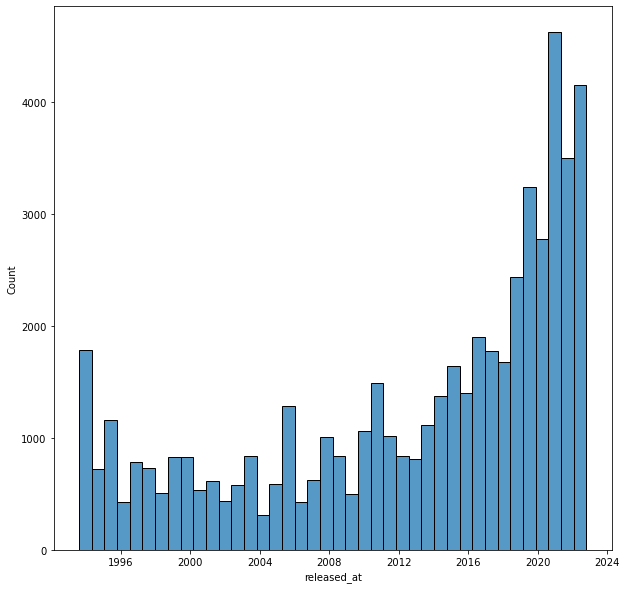

In [31]:
plt.figure(figsize=(10,10))
sns.histplot(data=train, x='released_at')

<AxesSubplot:xlabel='released_at', ylabel='usd'>

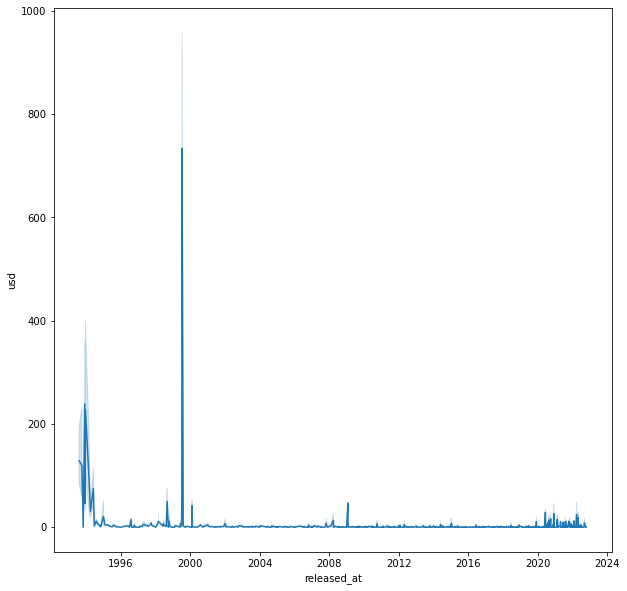

In [32]:
plt.figure(figsize=(10,10))
sns.lineplot(data=train, x='released_at', y='usd')

# look at outliers

In [33]:
def get_outlier_bounds(col, k):
    # k is the multiplier for the IQR rule
    q_one = col.describe()['50%']
    q_three = col.describe()['75%']
    iqr = q_three - q_one
    upper_bound = q_three + k*(iqr)
    lower_bound = q_one - k*(iqr)
    return lower_bound, upper_bound

def flag_column_outliers(df, col_name, k):
    lower_bound, upper_bound = get_outlier_bounds(df[col_name], k)
    df[f"outlier_{col_name}"] = False
    df.loc[df[col_name] < lower_bound, f"outlier_{col_name}"] = True
    df.loc[df[col_name] > upper_bound, f"outlier_{col_name}"] = True
    return df

In [34]:
flag_column_outliers(train, 'usd', 1.5)
flag_column_outliers(train, 'usd_foil', 1.5)

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,is_land,is_enchantment,is_artifact,is_sorcery,is_instant,is_legendary,is_token,is_split_card,outlier_usd,outlier_usd_foil
12661,2d911053-a026-4b20-ba2d-dbcc367c1413,Ajani Goldmane,en,2010-07-16,normal,True,highres_scan,{2}{W}{W},4.0,Legendary Planeswalker — Ajani,...,False,False,False,False,False,True,False,False,True,True
61300,dcb2e0d6-3181-4d3d-a3b4-3896288b2e0e,Champion of Lambholt,en,2020-08-07,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Human Warrior,...,False,False,False,False,False,False,False,False,False,True
48604,af3aa149-00fa-4932-b004-f64c8b5d3ca7,Gargoyle,en,2009-07-17,token,True,highres_scan,,0.0,Token Artifact Creature — Gargoyle,...,False,False,True,False,False,False,True,False,False,False
55734,c8d75604-4941-4faf-8f1a-7fc529e64962,Goblin Settler,en,2022-04-12,normal,True,highres_scan,{3}{R},4.0,Creature — Goblin,...,False,False,False,False,False,False,False,False,True,True
70638,feef03a1-f19a-413b-ad86-0b357cf9c09c,Weight Advantage,en,2016-08-26,normal,True,highres_scan,,0.0,Conspiracy,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,1e81e5fc-0e18-4dd8-a505-aa7dba8521a8,Kaboom!,en,2002-10-07,normal,True,highres_scan,{4}{R},5.0,Sorcery,...,False,False,False,True,False,False,False,False,False,True
54821,c59e3dd0-9cd4-4c65-9296-e2020a0df857,"Vraska, Relic Seeker",en,2017-09-29,normal,True,highres_scan,{4}{B}{G},6.0,Legendary Planeswalker — Vraska,...,False,False,False,False,False,True,False,False,True,True
66803,f0c02fd3-8051-4a35-b14a-462d765f42e5,Veteran Motorist,en,2020-11-12,normal,False,lowres,{R}{W},2.0,Creature — Dwarf Pilot,...,False,False,False,False,False,False,False,False,False,False
68710,f7ae5085-0d0d-4d7d-80a3-614315a07de5,"Liliana, the Last Hope",en,2022-07-08,normal,False,lowres,{1}{B}{B},3.0,Legendary Planeswalker — Liliana,...,False,False,False,False,False,True,False,False,True,True


In [35]:
train.outlier_usd.mean()

0.19239083441418073